In [1]:
#from data import CocoDatasetManager
from collections import Counter
from backbone import ClassificationRCNN
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt


In [2]:
#coco=CocoDatasetManager()
#dataset=coco.load_dataset_seperate_folder('test',"/workspaces/anaconda/src/data/test")

In [3]:
# Check if CUDA (GPU support) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading the dataset

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Load the dataset
train_dataset = datasets.ImageFolder(root='/home/amanandhar/Transferlearning/RCNN-classification/src/data/train', transform=transform)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)




In [5]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Load the dataset
full_dataset = datasets.ImageFolder(root='/home/amanandhar/Transferlearning/RCNN-classification/src/data/train', transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))  # 80% of the dataset
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [6]:
print("Number of training Images: ", len(train_dataset))
print("Number of test_loader: ", len(test_dataset))

Number of training Images:  7499
Number of test_loader:  1875


## Loading the model

In [7]:

# Assuming you have defined a model, loss function, and optimizer
model = ClassificationRCNN(num_classes=79)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/home/amanandhar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amanandhar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model = model.to(device)  # Move the model to GPU

In [9]:
model

ClassificationRCNN(
  (resnet_backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

## Training the model

In [10]:
num_epochs = 100
loss_graph = []
accuracy_graph = []

print(f"Starting training for {num_epochs} epochs.")

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    print(f"Epoch {epoch+1} started.")
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        try:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:  # Print every 10 batches
                loss_value = loss.item()
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch {i}, Loss: {loss_value:.4f}")

        except Exception as e:
            print(f"An error occurred: {e}")
    loss_graph.append(loss_value)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    accuracy = (correct_predictions / total_predictions) * 100
    accuracy_graph.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Training Loss: {loss.item():.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')


Starting training for 5 epochs.
Epoch 1 started.
Epoch [1/5], Batch 0, Loss: 4.3605
Epoch [1/5], Batch 10, Loss: 3.3033
Epoch [1/5], Batch 20, Loss: 3.8644
Epoch [1/5], Batch 30, Loss: 3.1445
Epoch [1/5], Batch 40, Loss: 3.3229
Epoch [1/5], Batch 50, Loss: 3.5229
Epoch [1/5], Batch 60, Loss: 2.8808
Epoch [1/5], Batch 70, Loss: 2.6731
Epoch [1/5], Batch 80, Loss: 3.1244
Epoch [1/5], Batch 90, Loss: 2.2564
Epoch [1/5], Batch 100, Loss: 3.1268
Epoch [1/5], Batch 110, Loss: 2.6956
Epoch [1/5], Batch 120, Loss: 3.0985
Epoch [1/5], Batch 130, Loss: 2.7060
Epoch [1/5], Batch 140, Loss: 2.9309
Epoch [1/5], Batch 150, Loss: 2.8616
Epoch [1/5], Batch 160, Loss: 3.0159
Epoch [1/5], Batch 170, Loss: 2.7234
Epoch [1/5], Batch 180, Loss: 3.3697
Epoch [1/5], Batch 190, Loss: 2.6794
Epoch [1/5], Batch 200, Loss: 3.0544
Epoch [1/5], Batch 210, Loss: 2.4222
Epoch [1/5], Batch 220, Loss: 3.3272
Epoch [1/5], Batch 230, Loss: 2.2659
Epoch [1/5] completed, Training Loss: 2.8823, Validation Loss: 2.8284, Acc

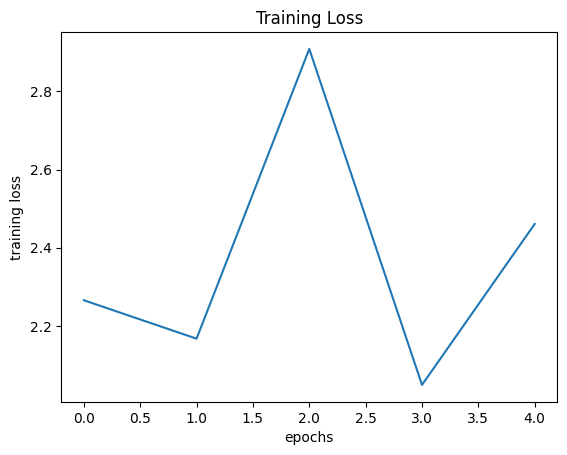

In [12]:
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(loss_graph)

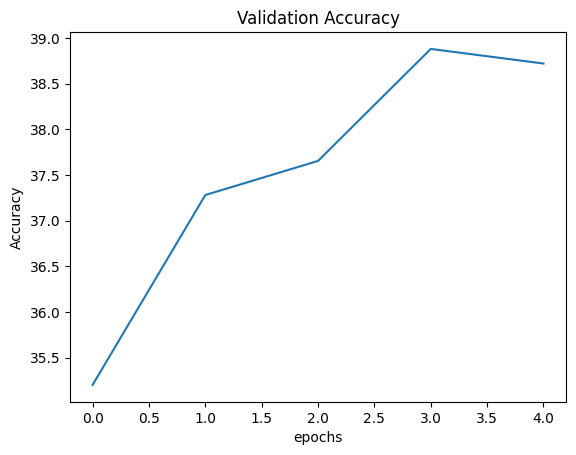

In [14]:
plt.title("Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.plot(accuracy_graph)